## **Setup**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from glob import glob
from IPython.display import display

In [12]:
npz_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all"

In [28]:
INCLUDE_SILENCE = True
SILENCE_CLASS = 20
NUM_FRETS = 20
NUM_CLASSES = NUM_FRETS + int(INCLUDE_SILENCE)

## **Data Inspect**

In [9]:
import numpy as np

npz_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz"
data = np.load(npz_path, allow_pickle=True)
print(data.files)  # ['audio', 'tablature', 'onsets', ...]

['track', 'fs', 'audio', 'tablature', 'tablature_adj', 'tablature_rel', 'onsets', 'notes', 'offsets', 'multi_pitch', 'pitch_list', 'hcqt', 'cqt', 'mel', 'stft', 'power']


In [5]:
import os

npz_path_list = [
    os.path.join(npz_dir, fname)
    for fname in sorted(os.listdir(npz_dir))
    if fname.endswith(".npz")
]

In [31]:
import numpy as np

def inspect_npz_structure(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    print(f"📁 Analyzing file: {os.path.basename(npz_path)}\n")

    summary = []

    for key in data.files:
        arr = data[key]
        info = {
            "Key": key,
            "Shape": arr.shape,
            "Dtype": arr.dtype,
            "Min": np.min(arr) if np.issubdtype(arr.dtype, np.number) else "-",
            "Max": np.max(arr) if np.issubdtype(arr.dtype, np.number) else "-",
        }
        summary.append(info)

    import pandas as pd
    df = pd.DataFrame(summary)
    return df

In [34]:
npz_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz"

df = inspect_npz_structure(npz_path)
display(df)

📁 Analyzing file: 00_BN1-129-Eb_comp.npz



,Key,Shape,Dtype,Min,Max
0,track,(),<U18,-,-
1,fs,(),int64,22050,22050
2,audio,"(492253,)",float32,-9.457,9.383601
3,tablature,"(6, 962)",int64,-1,8
4,tablature_adj,"(120, 962)",float64,0.0,1.0
5,tablature_rel,"(120, 962)",float64,-0.5,0.5
6,onsets,"(6, 44, 962)",float64,0.0,1.0
7,notes,"(6, 2)",object,-,-
8,offsets,"(6, 44, 962)",float64,0.0,1.0
9,multi_pitch,"(6, 44, 962)",float64,0.0,1.0


In [35]:
import numpy as np

npz = np.load(npz_path, allow_pickle=True)
adj = npz["tablature_adj"]  # shape: (120, 962)

print("tablature_adj shape:", adj.shape)
print("Value range:", adj.min(), "-", adj.max())

for t in range(5):
    active = np.where(adj[:, t] > 0.5)[0]
    print(f"t={t}: active indices →", active)

tablature_adj shape: (120, 962)
Value range: 0.0 - 1.0
t=0: active indices → []
t=1: active indices → []
t=2: active indices → []
t=3: active indices → [26 67 86]
t=4: active indices → [26 67 86]


In [36]:
onsets = npz["onsets"]  # shape: (6, 44, 962)

total_onsets = np.sum(onsets)
print(f"Total onsets: {total_onsets}")

for t in range(10):
    string, fret = np.where(onsets[:, :, t] > 0.5)
    if len(string) > 0:
        print(f"t={t}:")
        for s, f in zip(string, fret):
            print(f"  String {s}, Fret {f}")

Total onsets: 133.0
t=2:
  String 1, Fret 11
  String 3, Fret 22
  String 4, Fret 25


In [39]:
import numpy as np
import pandas as pd
from collections import Counter

def analyze_onset_distribution(npz_paths, max_fret=44, num_strings=6):
    """
    Verilen .npz dosyalarından tüm onsets verisini analiz eder.
    Her bir (fret, string) kombinasyonu için kaç kez onset gerçekleşmiş,
    bunu hesaplar ve dikey DataFrame olarak döner.

    Returns:
        pandas.DataFrame [Fret x String] → Count
    """
    onset_counter = Counter()

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        if "onsets" not in data:
            continue
        onsets = data["onsets"]  # Shape: (6, Fret, Time)

        for s in range(num_strings):
            for f in range(min(onsets.shape[1], max_fret)):
                count = int(np.sum(onsets[s, f] == 1.0))
                if count > 0:
                    onset_counter[(f, s)] += count

    # Veriyi Fret x String formatında dök
    df = pd.DataFrame(index=[f"Fret {f}" for f in range(max_fret)],
                      columns=[f"String {s+1}" for s in range(num_strings)],
                      dtype=int)

    for (f, s), c in onset_counter.items():
        df.at[f"Fret {f}", f"String {s+1}"] = c

    df.fillna(0, inplace=True)
    print("📊 Total Onset Distribution (Fret x String) Computed")
    return df

In [40]:
df = analyze_onset_distribution(npz_path_list)
display(df)

📊 Total Onset Distribution (Fret x String) Computed


,String 1,String 2,String 3,String 4,String 5,String 6
Fret 0,626.0,0.0,0.0,0.0,0.0,0.0
Fret 1,516.0,0.0,0.0,0.0,0.0,0.0
Fret 2,527.0,0.0,0.0,0.0,0.0,0.0
Fret 3,654.0,0.0,0.0,0.0,0.0,0.0
Fret 4,740.0,0.0,0.0,0.0,0.0,0.0
Fret 5,425.0,698.0,0.0,0.0,0.0,0.0
Fret 6,552.0,323.0,0.0,0.0,0.0,0.0
Fret 7,225.0,915.0,0.0,0.0,0.0,0.0
Fret 8,158.0,1098.0,0.0,0.0,0.0,0.0
Fret 9,123.0,1551.0,0.0,0.0,0.0,0.0


In [43]:
import numpy as np
import pandas as pd

def inspect_feature_tensors(npz_path, feature_keys=None):
    """
    Belirtilen .npz dosyasındaki özniteliklerin temel istatistiklerini döndürür.

    Args:
        npz_path (str): .npz dosyasının yolu
        feature_keys (list): Kontrol edilecek anahtarlar (varsayılan: hcqt, cqt, mel, stft, power)

    Returns:
        pd.DataFrame: Feature adı, shape, min, max, dtype
    """
    if feature_keys is None:
        feature_keys = ['hcqt', 'cqt', 'mel', 'stft', 'power']

    data = np.load(npz_path, allow_pickle=True)
    stats = []

    for key in feature_keys:
        if key not in data:
            continue
        tensor = data[key]
        stats.append({
            "Feature": key,
            "Shape": tensor.shape,
            "Min": float(np.min(tensor)),
            "Max": float(np.max(tensor)),
            "Dtype": str(tensor.dtype)
        })

    return pd.DataFrame(stats)

In [44]:
df = inspect_feature_tensors(npz_path)
print(df)

  Feature           Shape        Min  Max    Dtype
0    hcqt   (6, 144, 962)   0.000000  1.0  float32
1     cqt   (1, 192, 962)   0.000000  1.0  float32
2     mel   (1, 229, 962)   0.000000  1.0  float32
3    stft  (1, 1025, 962)   0.000000  1.0  float32
4   power          (962,) -66.271255  0.0  float32


In [45]:
import numpy as np
import librosa

def analyze_audio(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    audio = data['audio']
    sr = data['fs'].item()

    duration_sec = len(audio) / sr
    rms = np.sqrt(np.mean(audio ** 2))
    peak = np.max(np.abs(audio))
    db = 20 * np.log10(peak + 1e-10)

    print(f"🎧 Audio shape: {audio.shape}")
    print(f"📏 Duration: {duration_sec:.2f} sec")
    print(f"🧱 Sampling Rate: {sr}")
    print(f"📈 RMS: {rms:.4f}, Peak: {peak:.4f}, dBFS: {db:.2f}")

    silence_ratio = np.mean(np.abs(audio) < 0.01)
    print(f"🧘 Silence Ratio: {silence_ratio:.2%}")

    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    if len(pitches) > 0:
        print(f"🎵 Pitch range: {pitches.min():.2f} Hz - {pitches.max():.2f} Hz")
    else:
        print("⚠️ Pitch tracking failed (low energy or silence)")

    return audio, sr

In [46]:
analyze_audio(npz_path)

🎧 Audio shape: (492253,)
📏 Duration: 22.32 sec
🧱 Sampling Rate: 22050
📈 RMS: 1.0000, Peak: 9.4570, dBFS: 19.52
🧘 Silence Ratio: 1.61%
🎵 Pitch range: 146.31 Hz - 3972.73 Hz


(array([ 0.31945464,  0.47844216,  0.41357127, ..., -0.11243188,
        -0.101813  , -0.09873164], dtype=float32),
 22050)

In [51]:
import numpy as np
import os
import torch
import pandas as pd
from collections import Counter

def compute_per_string_class_distribution(npz_paths, num_strings=6, include_silence=True, num_classes=NUM_CLASSES):
    silence_class = num_classes - 1 if include_silence else None
    """
    Her tel (string) için sınıf dağılımı istatistiği çıkarır.
    Sessizlik class'ı -1 → class `total_frets` olarak sabitlenir.
    """
    counts = [Counter() for _ in range(num_strings)]

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        if "tablature" not in data:
            continue

        tab = data["tablature"]  # [6, T]

        for s in range(num_strings):
            frets = tab[s]

            if include_silence:
                frets = np.where(frets == -1, silence_class, frets)
            else:
                frets = frets[frets != -1]

            counts[s].update(frets.tolist())

    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in range(num_classes):
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i}" + (" (silence)" if include_silence and i == silence_class else "") for i in range(num_classes)]

    print("🎯 Class Distribution per String (Count + Ratio):")
    return df

In [53]:
class_distribution_df = compute_per_string_class_distribution(npz_path_list, include_silence=INCLUDE_SILENCE, num_classes=NUM_CLASSES)
display(class_distribution_df)

🎯 Class Distribution per String (Count + Ratio):


,String 1,String 2,String 3,String 4,String 5,String 6
Class 0,14633 (0.0310),9173 (0.0194),10788 (0.0228),11509 (0.0244),11671 (0.0247),9942 (0.0210)
Class 1,10799 (0.0229),5185 (0.0110),2122 (0.0045),10804 (0.0229),12022 (0.0254),6141 (0.0130)
Class 2,8937 (0.0189),15651 (0.0331),19238 (0.0407),15689 (0.0332),12583 (0.0266),5738 (0.0121)
Class 3,12138 (0.0257),18968 (0.0401),25406 (0.0538),20618 (0.0436),15071 (0.0319),7592 (0.0161)
Class 4,12493 (0.0264),24053 (0.0509),18142 (0.0384),17691 (0.0374),17007 (0.0360),9004 (0.0191)
Class 5,5996 (0.0127),11470 (0.0243),17533 (0.0371),18739 (0.0397),14573 (0.0308),8299 (0.0176)
Class 6,10385 (0.0220),22722 (0.0481),29131 (0.0616),31625 (0.0669),23594 (0.0499),10641 (0.0225)
Class 7,3384 (0.0072),9289 (0.0197),15560 (0.0329),21732 (0.0460),13770 (0.0291),5093 (0.0108)
Class 8,2450 (0.0052),11714 (0.0248),23350 (0.0494),19435 (0.0411),18591 (0.0393),8291 (0.0175)
Class 9,1449 (0.0031),3852 (0.0082),9212 (0.0195),11752 (0.0249),10985 (0.0232),4548 (0.0096)


In [87]:
import pandas as pd

def build_resample_strategy(distribution_df, silence_fret=20,
                            low_thresh=50, mid_thresh=200, high_thresh=2000):
    """
    Fret-string kombinasyonlarına göre veri dengeleme stratejisi oluşturur.
    - upsample_hard: çok az görülen → augment
    - upsample: az görülen → augment
    - downsample: çok fazla görülen → rastgele alt küme
    - ignore: hiç görülmeyen → işleme alma
    - silence: sessizlik freti → özel yönetilir
    - leave: dengeli → bırak

    Returns: dict {(string, fret): strategy}
    """
    strategy = {}

    for class_idx, row in distribution_df.iterrows():
        fret = int(class_idx.replace("Class", "").split()[0])

        for s_idx, cell in enumerate(row):
            try:
                count = int(cell.split(" ")[0])
            except:
                continue  # Geçersiz hücreyi atla

            key = (s_idx, fret)

            if count == 0:
                strategy[key] = "ignore"
            elif fret == silence_fret:
                strategy[key] = "silence"
            elif count < low_thresh:
                strategy[key] = "upsample_hard"
            elif count < mid_thresh:
                strategy[key] = "upsample"
            elif count > high_thresh:
                strategy[key] = "downsample"
            else:
                strategy[key] = "leave"

    return strategy

In [88]:
from pprint import pprint

strategy_map = build_resample_strategy(class_distribution_df)
pprint({k: v for k, v in strategy_map.items() if v != "leave"})

{(0, 0): 'downsample',
 (0, 1): 'downsample',
 (0, 2): 'downsample',
 (0, 3): 'downsample',
 (0, 4): 'downsample',
 (0, 5): 'downsample',
 (0, 6): 'downsample',
 (0, 7): 'downsample',
 (0, 8): 'downsample',
 (0, 11): 'upsample',
 (0, 12): 'upsample',
 (0, 13): 'ignore',
 (0, 14): 'upsample_hard',
 (0, 15): 'ignore',
 (0, 16): 'ignore',
 (0, 17): 'ignore',
 (0, 18): 'ignore',
 (0, 19): 'ignore',
 (0, 20): 'silence',
 (1, 0): 'downsample',
 (1, 1): 'downsample',
 (1, 2): 'downsample',
 (1, 3): 'downsample',
 (1, 4): 'downsample',
 (1, 5): 'downsample',
 (1, 6): 'downsample',
 (1, 7): 'downsample',
 (1, 8): 'downsample',
 (1, 9): 'downsample',
 (1, 10): 'downsample',
 (1, 13): 'upsample_hard',
 (1, 14): 'ignore',
 (1, 15): 'ignore',
 (1, 16): 'ignore',
 (1, 17): 'ignore',
 (1, 18): 'ignore',
 (1, 19): 'ignore',
 (1, 20): 'silence',
 (2, 0): 'downsample',
 (2, 1): 'downsample',
 (2, 2): 'downsample',
 (2, 3): 'downsample',
 (2, 4): 'downsample',
 (2, 5): 'downsample',
 (2, 6): 'downsample'

In [57]:
import numpy as np
from typing import Tuple, Dict, List

def extract_audio_segments_by_strategy(npz_path: str,
                                       strategy_map: Dict[Tuple[int, int], str],
                                       silence_class: int = 20) -> Dict[str, List[np.ndarray]]:
    """
    Belirli bir .npz dosyasındaki tablature'a göre audio frame'lerini strategy_map'e göre ayırır.

    Returns:
        Dict[str, List[np.ndarray]]: {'downsample': [...], 'upsample': [...], 'upsample_hard': [...]}
    """
    data = np.load(npz_path, allow_pickle=True)
    audio = data["audio"]
    tablature = data["tablature"]  # (6, T)

    num_frames = tablature.shape[1]
    frame_len = len(audio) // num_frames  # her frame için sample sayısı

    buckets = {
        "downsample": [],
        "upsample": [],
        "upsample_hard": []
    }

    for t in range(num_frames):
        frame_audio = audio[t * frame_len : (t + 1) * frame_len]
        for s in range(6):  # 6 string
            fret = tablature[s, t]
            if fret == -1:
                fret = silence_class
            tag = strategy_map.get((s, fret), None)
            if tag in buckets:
                buckets[tag].append(frame_audio)
                break

    return buckets

In [58]:
results = []
for path in npz_paths:
    result = analyze_npz_strategy(path, strategy_map)
    if result:
        results.append(result)

# Hangi dosyada ne yapılacak özetle
from pprint import pprint
for r in results[:5]:  # ilk 5 dosya için
    print(f"🎼 {os.path.basename(r['file'])}: {r['actions']}")

🎼 00_BN1-129-Eb_comp.npz: {'downsample', 'silence'}
🎼 00_BN1-129-Eb_solo.npz: {'downsample', 'silence'}
🎼 00_BN1-147-Gb_comp.npz: {'downsample', 'silence'}
🎼 00_BN1-147-Gb_solo.npz: {'downsample', 'silence', 'leave'}
🎼 00_BN2-131-B_comp.npz: {'downsample', 'silence', 'leave'}


In [70]:
from collections import Counter
import numpy as np

def count_fret_string_combinations(npz_path: str, silence_class: int = 20) -> Counter:
    data = np.load(npz_path, allow_pickle=True)
    tablature = data["tablature"]  # (6, T)

    counter = Counter()
    for s in range(6):  # string
        for t in range(tablature.shape[1]):  # time
            fret = tablature[s, t]
            if fret == -1:
                fret = silence_class
            counter[(s, fret)] += 1

    return counter

In [71]:
comb_counts = count_fret_string_combinations(npz_path)

# Dikey tablo halinde sıralı görelim:
for (s, f), count in sorted(comb_counts.items()):
    print(f"String {s+1}, Fret {f:>2}: {count}")

String 1, Fret  4: 101
String 1, Fret  6: 84
String 1, Fret 20: 777
String 2, Fret  5: 13
String 2, Fret  6: 482
String 2, Fret  8: 20
String 2, Fret 20: 447
String 3, Fret  5: 7
String 3, Fret  6: 140
String 3, Fret  7: 20
String 3, Fret  8: 408
String 3, Fret 20: 387
String 4, Fret  5: 106
String 4, Fret  7: 432
String 4, Fret  8: 90
String 4, Fret 20: 334
String 5, Fret  6: 205
String 5, Fret  8: 236
String 5, Fret 20: 521
String 6, Fret  6: 154
String 6, Fret  8: 74
String 6, Fret 20: 734


In [73]:
from collections import Counter
import numpy as np

def adjust_strategy_for_file(npz_path: str,
                             global_strategy: dict,
                             silence_class: int = 20,
                             low_threshold: int = 10) -> dict:
    """
    Global strategy haritasına göre bu dosya özelinde lokal strateji çıkarır.
    - upsample / upsample_hard her zaman korunur
    - downsample sadece bu dosyada da fazla varsa uygulanır, azsa 'leave'
    - silence ve ignore aynen korunur
    """

    # 🔢 1. Tablature'dan lokal (string, fret) frekanslarını say
    data = np.load(npz_path, allow_pickle=True)
    tablature = data["tablature"]  # [6, T]
    local_counter = Counter()

    for s in range(tablature.shape[0]):
        for t in range(tablature.shape[1]):
            f = tablature[s, t]
            if f == -1:
                f = silence_class
            local_counter[(s, f)] += 1

    # 🧠 2. Global stratejiye göre karar ver
    new_strategy = {}
    for key, global_label in global_strategy.items():
        local_count = local_counter.get(key, 0)

        if global_label in ["upsample", "upsample_hard"]:
            new_strategy[key] = global_label  # her durumda uygula
        elif global_label == "downsample":
            if local_count < low_threshold:
                new_strategy[key] = "leave"  # azsa bırak
            else:
                new_strategy[key] = "downsample"
        else:
            new_strategy[key] = global_label  # ignore, silence, leave vs.

    return new_strategy

In [81]:
local_strategy = adjust_strategy_for_file(npz_path, strategy_map, silence_class=20)
from collections import Counter
summary = Counter(local_strategy.values())
print(summary)

Counter({'leave': 70, 'ignore': 16, 'downsample': 15, 'upsample_hard': 13, 'upsample': 6, 'silence': 6})


In [62]:
import numpy as np
from typing import Tuple, Dict, List

def extract_audio_segments_by_strategy(npz_path: str,
                                       strategy_map: Dict[Tuple[int, int], str],
                                       silence_class: int = 20) -> Dict[str, List[np.ndarray]]:
    """
    Belirli bir .npz dosyasındaki tablature'a göre audio frame'lerini strategy_map'e göre ayırır.

    Returns:
        Dict[str, List[np.ndarray]]: {'downsample': [...], 'upsample': [...], 'upsample_hard': [...]}
    """
    data = np.load(npz_path, allow_pickle=True)
    audio = data["audio"]
    tablature = data["tablature"]  # (6, T)

    num_frames = tablature.shape[1]
    frame_len = len(audio) // num_frames  # her frame için sample sayısı

    buckets = {
        "downsample": [],
        "upsample": [],
        "upsample_hard": []
    }

    for t in range(num_frames):
        frame_audio = audio[t * frame_len : (t + 1) * frame_len]
        for s in range(6):  # 6 string
            fret = tablature[s, t]
            if fret == -1:
                fret = silence_class
            tag = strategy_map.get((s, fret), None)
            if tag in buckets:
                buckets[tag].append(frame_audio)
                break  # frame birden fazla kez alınmamalı

    return buckets


In [64]:
segments = extract_audio_segments_by_strategy(
    npz_path=npz_path,
    strategy_map=strategy_map,
    silence_class=20
)

print(segments)

Output hidden; open in https://colab.research.google.com to view.

In [65]:
import random
import numpy as np
from typing import List

def downsample_segment_list(segments: List[np.ndarray], target_fraction: float = 0.3, seed: int = 42) -> List[np.ndarray]:
    """
    Downsample işlemi: Verilen audio segment listesinden rastgele bir altküme seçer.

    Args:
        segments: Orijinal audio segment listesi (örneğin: segments["downsample"])
        target_fraction: Ne kadarını koruyalım? (0.3 → %30)
        seed: Reprodüksiyon için random seed

    Returns:
        Downsample edilmiş segment listesi
    """
    if not segments:
        return []

    random.seed(seed)
    k = max(1, int(len(segments) * target_fraction))  # en az 1 frame kalsın
    return random.sample(segments, k)

In [66]:
downsampled_segments = downsample_segment_list(segments["downsample"], target_fraction=0.25)
print(f"🔻 Downsampled {len(segments['downsample'])} → {len(downsampled_segments)} segments")

🔻 Downsampled 863 → 215 segments


In [67]:
import numpy as np
import random
from typing import List, Tuple

def augment_audio_segment(segment: np.ndarray,
                          pitch_shift_semitones: List[float] = [-1.0, 0.0, 1.0],
                          gain_range: Tuple[float, float] = (0.8, 1.2),
                          noise_level: float = 0.005,
                          stretch_factors: List[float] = [0.95, 1.0, 1.05],
                          sr: int = 22050) -> np.ndarray:
    """
    Tek bir audio segmenti augment eder.
    - Gain (volume scale)
    - Pitch shift (resample)
    - Noise ekleme
    - Time stretch (resample)

    Returns: Augmented audio segment
    """
    # Gain
    gain = random.uniform(*gain_range)
    segment = segment * gain

    # Noise ekle
    noise = np.random.normal(0, noise_level, size=segment.shape)
    segment = segment + noise

    # Pitch shift (resample)
    pitch_semitone = random.choice(pitch_shift_semitones)
    pitch_factor = 2 ** (pitch_semitone / 12)
    segment = np.interp(
        np.linspace(0, len(segment), int(len(segment) / pitch_factor), endpoint=False),
        np.arange(len(segment)),
        segment
    )

    # Time stretch (resample)
    stretch = random.choice(stretch_factors)
    segment = np.interp(
        np.linspace(0, len(segment), int(len(segment) * stretch), endpoint=False),
        np.arange(len(segment)),
        segment
    )

    # Normalize
    segment = np.clip(segment, -1.0, 1.0)

    return segment

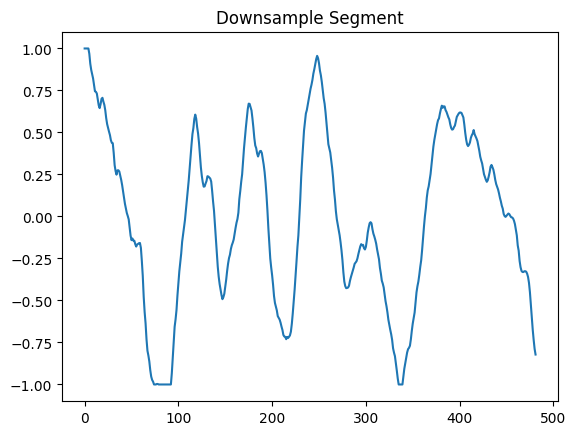

In [84]:
seg = segments["downsample"][0]
aug = augment_audio_segment(seg)

import matplotlib.pyplot as plt
plt.plot(aug)
plt.title("Downsample Segment")
plt.show()

In [85]:
for k, v in segments.items():
    print(f"{k}: {len(v)} segments")

downsample: 863 segments
upsample: 0 segments
upsample_hard: 0 segments


In [92]:
def analyze_strategy_distribution(npz_paths, strategy_map, silence_class=20, low_threshold=10):
    """
    Tüm npz dosyaları için lokal stratejiyi çıkarır ve hangi kombinasyonun kaç kez
    hangi şekilde (downsample, upsample, vs.) etiketlendiğini hesaplar.
    """
    strategy_counter = defaultdict(lambda: defaultdict(int))

    for npz_path in npz_paths:
        local_strategy = adjust_strategy_for_file(npz_path, strategy_map, silence_class, low_threshold)
        for key, action in local_strategy.items():
            strategy_counter[key][action] += 1

    rows = []
    for (s, f), actions in sorted(strategy_counter.items()):
        row = {"String": s, "Fret": f}
        row.update(actions)
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.fillna(0).sort_values(["String", "Fret"]).reset_index(drop=True)
    print("✅ Strategy distribution table created.")
    return df

In [93]:
npz_paths = [os.path.join(npz_dir, f) for f in os.listdir(npz_dir) if f.endswith(".npz")]

strategy_distribution_df = analyze_strategy_distribution(npz_paths, strategy_map)

display(strategy_distribution_df)

✅ Strategy distribution table created.


,String,Fret,leave,downsample,upsample,ignore,upsample_hard,silence
0,0,0,269.0,91.0,0.0,0.0,0.0,0.0
1,0,1,309.0,51.0,0.0,0.0,0.0,0.0
2,0,2,294.0,66.0,0.0,0.0,0.0,0.0
3,0,3,281.0,79.0,0.0,0.0,0.0,0.0
4,0,4,271.0,89.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
121,5,16,0.0,0.0,360.0,0.0,0.0,0.0
122,5,17,0.0,0.0,0.0,0.0,360.0,0.0
123,5,18,0.0,0.0,0.0,360.0,0.0,0.0
124,5,19,0.0,0.0,0.0,360.0,0.0,0.0


## **Applying Balancing Techniques**


In [94]:
import numpy as np

def determine_segment_actions_for_file(npz_path, global_strategy, silence_class=20):
    """
    Verilen .npz dosyasındaki tüm frame'ler için aksiyonları belirler.

    Args:
        npz_path: .npz dosya yolu
        global_strategy: {(string, fret): action} sözlüğü
        silence_class: -1 yerine kullanılacak fret değeri (varsayılan: 20)

    Returns:
        List[str]: Her frame için uygulanan aksiyonlar
    """
    data = np.load(npz_path, allow_pickle=True)

    if "tablature" not in data:
        raise ValueError(f"'tablature' verisi bulunamadı: {npz_path}")

    tablature = data["tablature"]  # shape: (6, T)
    num_frames = tablature.shape[1]

    actions_per_frame = []

    for t in range(num_frames):
        tab_segment = tablature[:, t]  # shape: (6,)
        actions = []

        for string_idx, fret in enumerate(tab_segment):
            key = (string_idx, fret if fret != -1 else silence_class)
            action = global_strategy.get(key, "ignore")
            actions.append(action)

        # Frame seviyesinde karar: en baskın (majority) aksiyonu al
        unique, counts = np.unique(actions, return_counts=True)
        majority_action = unique[np.argmax(counts)]
        actions_per_frame.append(majority_action)

    return actions_per_frame

In [95]:
def extract_segments(npz_data, segment_length=512):
    """
    Audio ve tablature verisinden segmentlere ayırır.
    """
    audio = npz_data["audio"]
    tablature = npz_data["tablature"]  # (6, T)
    total_frames = tablature.shape[1]

    segments = []
    for start in range(0, total_frames - segment_length, segment_length):
        end = start + segment_length
        seg_audio = audio[start * 512 : end * 512]  # 512 hop size varsayımı
        seg_tab = tablature[:, start:end]

        segments.append({
            "audio": seg_audio,
            "tablature": seg_tab,
            "start_frame": start,
            "end_frame": end
        })

    return segments

In [96]:
def write_new_npz(original_data, processed_segments, output_path):
    """
    İşlenmiş segmentlerden yeni .npz dosyası oluşturur.
    """
    new_audio = np.concatenate([seg["audio"] for seg in processed_segments], axis=0)
    new_tab = np.concatenate([seg["tablature"] for seg in processed_segments], axis=1)

    # Diğer öznitelikler boş bırakılabilir, istersen HCQT, onsets yeniden hesaplanabilir
    np.savez(output_path,
             audio=new_audio.astype(np.float32),
             tablature=new_tab.astype(np.int64))

In [100]:
import numpy as np
import random
import os

def process_and_save_file(npz_path, global_strategy, output_dir, segment_length=512, silence_class=20):
    # 1. Dosyayı yükle
    data = np.load(npz_path, allow_pickle=True)

    # 2. Her frame için aksiyonları bul
    actions_per_frame = determine_segment_actions_for_file(npz_path, global_strategy, silence_class)

    # 3. Segmentlere ayır
    segments = extract_segments(data, segment_length=segment_length)

    processed_segments = []
    for seg in segments:
        s, e = seg["start_frame"], seg["end_frame"]
        segment_actions = actions_per_frame[s:e]

        # Bu segment için majority aksiyon belirle
        unique, counts = np.unique(segment_actions, return_counts=True)
        majority = unique[np.argmax(counts)]

        if majority == "ignore" or majority == "silence":
            continue
        elif majority == "downsample":
            if random.random() > 0.5:  # %50 ihtimalle al
                processed_segments.append(seg)
        elif majority in ["upsample", "upsample_hard"]:
            processed_segments.append(seg)
            # Basit augment (amplitude jitter) uygula
            augmented = seg.copy()
            augmented["audio"] = seg["audio"] * (0.9 + 0.2 * np.random.rand())
            processed_segments.append(augmented)
        else:  # leave
            processed_segments.append(seg)

    if not processed_segments:
        print(f"⚠️ No valid segments for {npz_path}, skipping.")
        return

    # 4. Yeni dosyayı yaz
    filename = os.path.basename(npz_path)
    output_path = os.path.join(output_dir, filename)
    write_new_npz(data, processed_segments, output_path)

    print(f"✅ Saved to {output_path}, total segments: {len(processed_segments)}")

In [101]:
example_npz = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz"
output_dir = "/content/processed_output"

os.makedirs(output_dir, exist_ok=True)

process_and_save_file(example_npz, strategy_map, output_dir)

✅ Saved to /content/processed_output/00_BN1-129-Eb_comp.npz, total segments: 1


In [103]:
import numpy as np
import matplotlib.pyplot as plt

def compare_npz(original_path, processed_path):
    orig = np.load(original_path, allow_pickle=True)
    proc = np.load(processed_path, allow_pickle=True)

    print("🔍 Tablature Frame Sayısı")
    print(f"Original : {orig['tablature'].shape[1]} frames")
    print(f"Processed: {proc['tablature'].shape[1]} frames\n")

    print("🔊 Audio Sample Count")
    print(f"Original : {orig['audio'].shape[0]} samples")
    print(f"Processed: {proc['audio'].shape[0]} samples\n")

    # Orijinal ve işlenmiş audio'nun ilk 2 saniyesini çiz
    sr = 22050
    plt.figure(figsize=(12, 4))
    plt.plot(orig['audio'][:2*sr], label='Original')
    plt.plot(proc['audio'][:2*sr], label='Processed', alpha=0.7)
    plt.title("Audio Comparison (First 2 seconds)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Tablature yoğunluk heatmap karşılaştırması (string-fret count)
    def tab_distribution(tab):
        from collections import Counter
        dist = Counter()
        for s in range(6):
            frets = tab[s]
            for f in frets:
                dist[(s, f)] += 1
        return dist

    from collections import Counter
    orig_dist = tab_distribution(orig['tablature'])
    proc_dist = tab_distribution(proc['tablature'])

    print("\n📊 Orijinal ve İşlenmiş Fret-String Dağılımları (ilk 10):")
    print("Original :", dict(list(orig_dist.items())[:10]))
    print("Processed:", dict(list(proc_dist.items())[:10]))


🔍 Tablature Frame Sayısı
Original : 962 frames
Processed: 512 frames

🔊 Audio Sample Count
Original : 492253 samples
Processed: 262144 samples



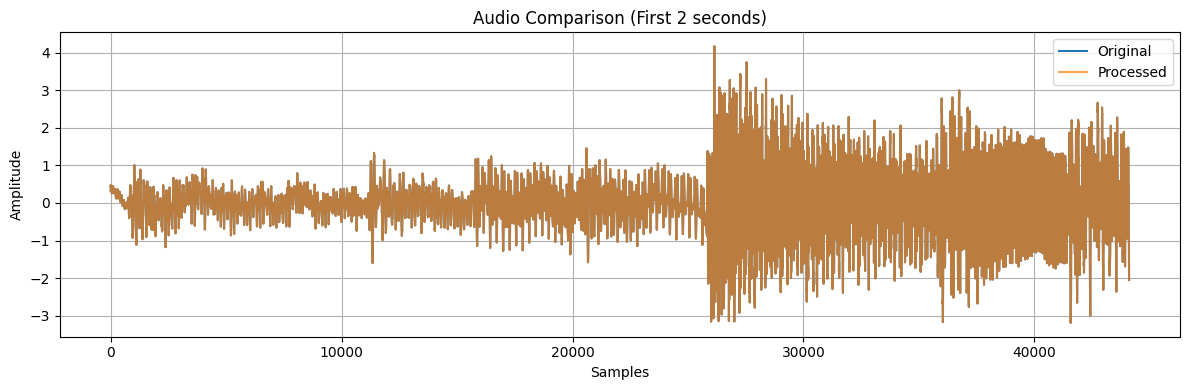


📊 Orijinal ve İşlenmiş Fret-String Dağılımları (ilk 10):
Original : {(0, np.int64(-1)): 777, (0, np.int64(4)): 101, (0, np.int64(6)): 84, (1, np.int64(-1)): 447, (1, np.int64(6)): 482, (1, np.int64(8)): 20, (1, np.int64(5)): 13, (2, np.int64(-1)): 387, (2, np.int64(8)): 408, (2, np.int64(6)): 140}
Processed: {(0, np.int64(-1)): 443, (0, np.int64(4)): 69, (1, np.int64(-1)): 196, (1, np.int64(6)): 316, (2, np.int64(-1)): 145, (2, np.int64(8)): 242, (2, np.int64(6)): 110, (2, np.int64(7)): 15, (3, np.int64(-1)): 140, (3, np.int64(7)): 214}


In [104]:
compare_npz(
    "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz",
    "/content/processed_output/00_BN1-129-Eb_comp.npz"
)

In [105]:
import numpy as np
import pandas as pd
from collections import Counter

def compute_distribution_single_npz(npz_path, num_strings=6, include_silence=True, num_classes=21):
    silence_class = num_classes - 1 if include_silence else None
    """
    Tek bir .npz dosyası için, her tel (string) üzerindeki sınıf dağılımını hesaplar.
    Sessizlik class'ı (-1) → class `num_classes - 1` olarak yeniden atanır.
    """
    counts = [Counter() for _ in range(num_strings)]

    data = np.load(npz_path, allow_pickle=True)
    if "tablature" not in data:
        raise ValueError("❌ 'tablature' anahtarı .npz dosyasında bulunamadı.")

    tab = data["tablature"]  # shape: [6, T]

    for s in range(num_strings):
        frets = tab[s]

        if include_silence:
            frets = np.where(frets == -1, silence_class, frets)
        else:
            frets = frets[frets != -1]

        counts[s].update(frets.tolist())

    # DataFrame oluştur
    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in range(num_classes):
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i}" + (" (silence)" if include_silence and i == silence_class else "") for i in range(num_classes)]

    print(f"🎯 Class Distribution for: {npz_path}")
    return df

In [106]:
from glob import glob
df = compute_distribution_single_npz(example_npz, include_silence=INCLUDE_SILENCE)
from IPython.display import display
display(df)

🎯 Class Distribution for: /content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz


,String 1,String 2,String 3,String 4,String 5,String 6
Class 0,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 1,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 2,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 3,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 4,101 (0.1050),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 5,0 (0.0000),13 (0.0135),7 (0.0073),106 (0.1102),0 (0.0000),0 (0.0000)
Class 6,84 (0.0873),482 (0.5010),140 (0.1455),0 (0.0000),205 (0.2131),154 (0.1601)
Class 7,0 (0.0000),0 (0.0000),20 (0.0208),432 (0.4491),0 (0.0000),0 (0.0000)
Class 8,0 (0.0000),20 (0.0208),408 (0.4241),90 (0.0936),236 (0.2453),74 (0.0769)
Class 9,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)


In [107]:
from glob import glob
df = compute_distribution_single_npz("/content/processed_output/00_BN1-129-Eb_comp.npz", include_silence=INCLUDE_SILENCE)
from IPython.display import display
display(df)

🎯 Class Distribution for: /content/processed_output/00_BN1-129-Eb_comp.npz


,String 1,String 2,String 3,String 4,String 5,String 6
Class 0,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 1,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 2,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 3,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 4,69 (0.1348),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 5,0 (0.0000),0 (0.0000),0 (0.0000),73 (0.1426),0 (0.0000),0 (0.0000)
Class 6,0 (0.0000),316 (0.6172),110 (0.2148),0 (0.0000),163 (0.3184),86 (0.1680)
Class 7,0 (0.0000),0 (0.0000),15 (0.0293),214 (0.4180),0 (0.0000),0 (0.0000)
Class 8,0 (0.0000),0 (0.0000),242 (0.4727),85 (0.1660),108 (0.2109),74 (0.1445)
Class 9,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
